# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import joblib

### Import custom DNN

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../models"))

from NN import NeuralNet

# Data Exploration

In [3]:
df = pd.read_csv('../data/glass.csv')
print("Dataset shape:", df.shape)

Dataset shape: (214, 10)


In [4]:
print(df.head())

        RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


Пропущених значень не виявлено, а всі ознаки числові.

In [6]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


Ненормальні розподіли у колонках 'Ba' та 'Fe', може вплинути на якість моделі. Великі значення 'Si' адже це основний компонент скла.

Class distribution:
 Type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64


/var/folders/s_/8hj1mz7936v_r35_6yq1g5jc0000gp/T/ipykernel_60075/3069970884.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Type', data=df, palette='Set1')


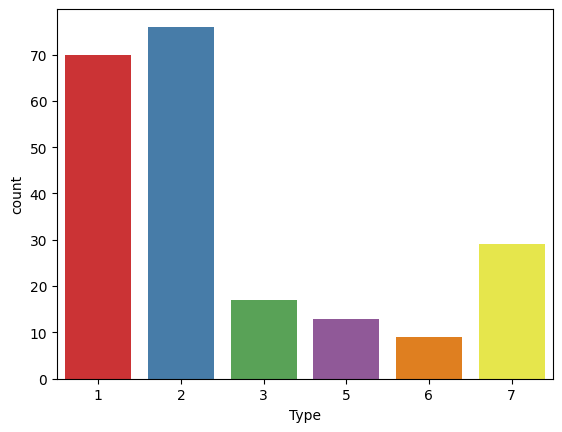

In [7]:
print("Class distribution:\n", df['Type'].value_counts())

sns.countplot(x='Type', data=df, palette='Set1')
plt.show()

Сильно не збалансовані класи, можна використати SMOTE оверсемплінг.

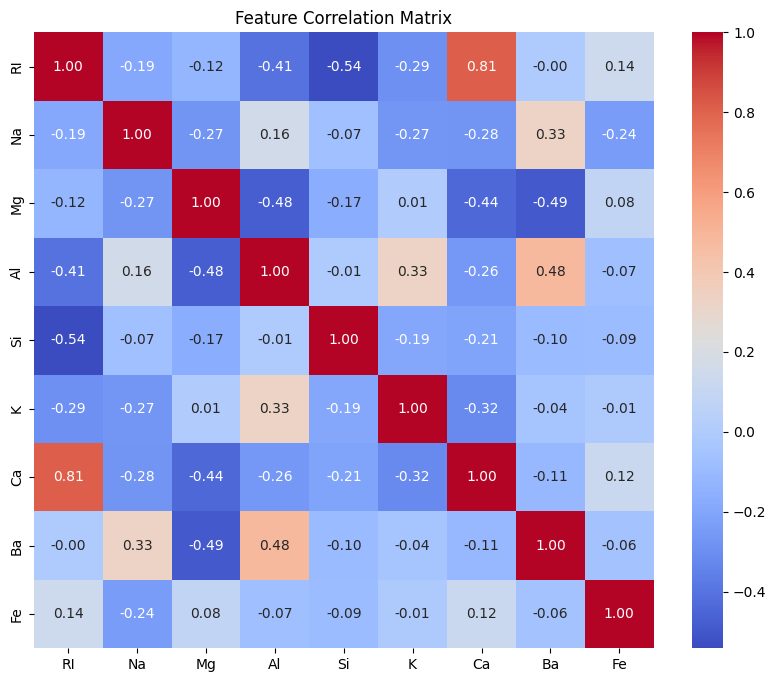

In [8]:
# Correlation matrix
corr = df.drop('Type', axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

Сильна кореляція між 'RI' та 'Ca', якщо експериментально підтвердиться, що якість моделі зростає без 'Ca', тоді можна позбутись 'Ca'.

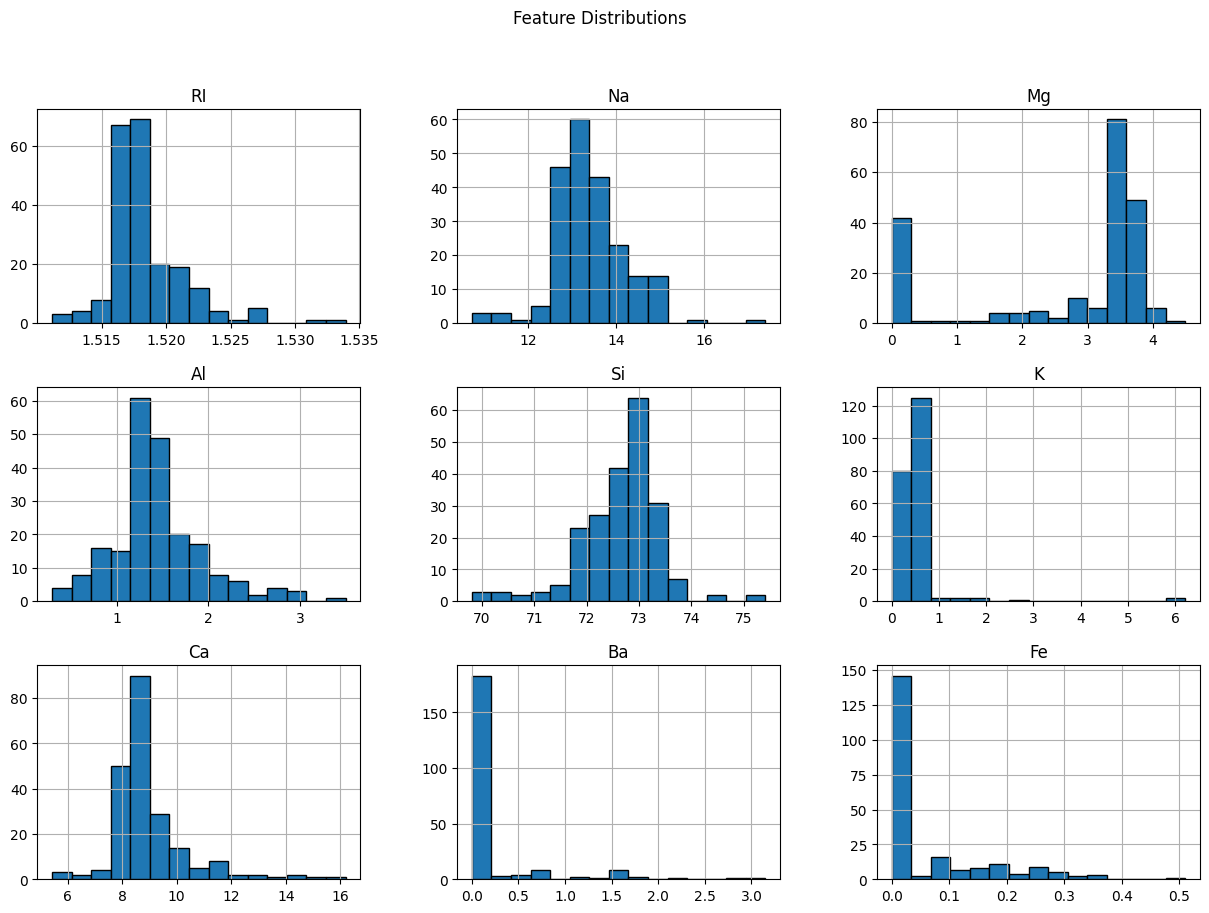

In [9]:
# Distributions of features
df.drop('Type', axis=1).hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.suptitle('Feature Distributions')
plt.show()

Дані потребують приведення до нормального розподілу.

# Data Preprocessing
### Функція для заміни аномалій
Функція замінює викиди у вибраних колонках за допомогою методу IQR, обмежуючи значення межами нижнього та верхнього квартилів, а потім застосовується до всіх ознак окрім цільової.


In [10]:
def replace_outliers_iqr(df, features, k=1.5):
    capped = df.copy()
    for col in features:
        Q1 = capped[col].quantile(0.25)
        Q3 = capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        capped[col] = np.where(capped[col] < lower, lower,
                               np.where(capped[col] > upper, upper, capped[col]))
    return capped

features = df.columns.drop('Type')
data_clean = replace_outliers_iqr(df, features)

In [11]:
y = data_clean['Type']
X = data_clean.drop(['Type'], axis=1)

### Розбиття даних на підвибірки

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Оверсемплінг

/var/folders/s_/8hj1mz7936v_r35_6yq1g5jc0000gp/T/ipykernel_60075/819988834.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="Set2")


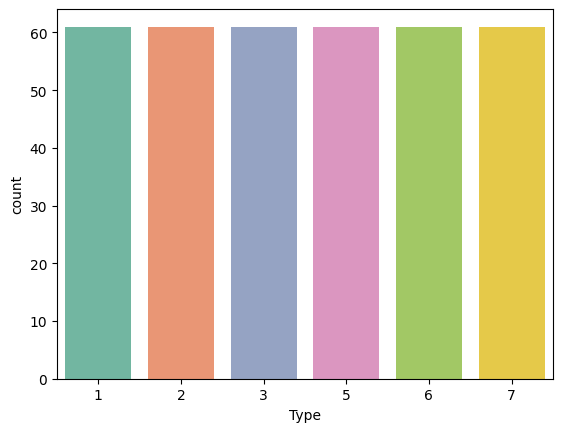

In [13]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

sns.countplot(x=y_train, palette="Set2")
plt.show()

Класи збалансовані

## Model Selection

Перевіряємо точність кількох класифікаторів із попередньою трансформацією даних Yeo-Johnson, використовуючи крос-валідацію, та визначаємо найкращу модель за середньою точністю.

Yeo-Johnson трансформація застосовується для стабілізації дисперсії та наближення розподілу ознак до нормального. На відміну від Box-Cox, Yeo-Johnson працює з нульовими та від’ємними значеннями.

In [14]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

In [15]:
results = {}
for name, clf in classifiers.items():
    model = Pipeline(steps=[
        ('preprocessor', PowerTransformer('yeo-johnson')),
        ('classifier', clf)
    ])
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = scores.mean()
    print(f"{name}: Mean CV Accuracy = {scores.mean():.4f}")

Logistic Regression: Mean CV Accuracy = 0.7352
KNN: Mean CV Accuracy = 0.7899
Random Forest: Mean CV Accuracy = 0.8745
Gradient Boosting: Mean CV Accuracy = 0.8745


In [16]:
best_model_name = max(results, key=results.get)
print(f"\nBest model based on CV accuracy: {best_model_name}")



Best model based on CV accuracy: Gradient Boosting


## Feature Selection

Визначаємо важливість ознак моделі (Random Forest), візуалізуємо їх, потім поетапно оцінюємо точність моделі з різною кількістю найважливіших ознак за допомогою крос-валідації та будуємо відповідний графік. Далі формуємо новий препроцесор і вибираємо лише ці відфільтровані ознаки для подальшого навчання.

In [17]:
importances = classifiers[best_model_name].fit(X_train, y_train).feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

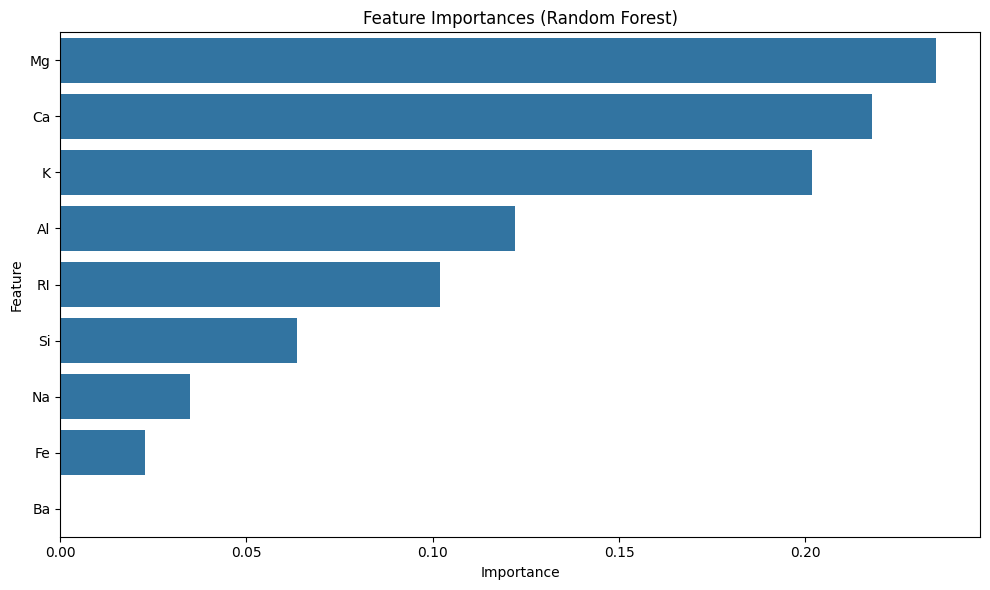

In [18]:
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

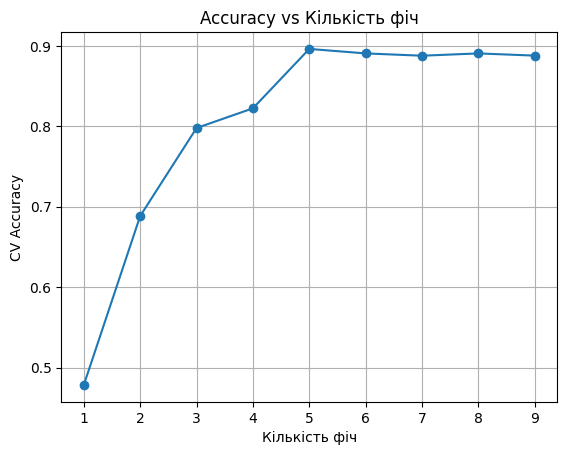

In [19]:
sorted_features = importance_df.sort_values('importance', ascending=False)['feature'].tolist()

results = []
for k in range(1, len(sorted_features) + 1):
    selected = sorted_features[:k]
    
    model = RandomForestClassifier(random_state=42)
    scores = cross_val_score(model, X_train[selected], y_train, cv=5, scoring='accuracy')
    results.append((k, scores.mean()))

# Графік
ks, accs = zip(*results)
plt.plot(ks, accs, marker='o')
plt.xlabel('Кількість фіч')
plt.ylabel('CV Accuracy')
plt.title('Accuracy vs Кількість фіч')
plt.grid()
plt.show()

In [20]:
selected_features = importance_df[importance_df['importance'] > 0.03]['feature'].tolist()
selected_features.append('Ba') # додаю 'Ba' назад через експериментально доведений приріст якості класифікації

print("\nSelected features with importance > 0.05:")
print(selected_features)


Selected features with importance > 0.05:
['Mg', 'Ca', 'K', 'Al', 'RI', 'Si', 'Na', 'Ba']


In [21]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

### Перероблюємо препроцесор

In [22]:
numeric_features_selected = selected_features

numeric_transformer = Pipeline(steps=[
    ('power', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_selected)
    ]
)

## Hyperparameter Tuning

Проводимо пошук найкращих гіперпараметрів для Random Forest за допомогою GridSearchCV, після чого створюємо фінальний пайплайн з оптимізованою моделлю і тренуємо його на всіх тренувальних даних.


In [23]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample'] 
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

In [24]:
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

best_rf_model = grid_search.best_estimator_

Best parameters: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 200}
Best cross-validation accuracy: 0.8990


In [25]:
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_rf_model)
])
final_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Mg', 'Ca', 'K', 'Al', 'RI',
                                                   'Si', 'Na', 'Ba'])])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced',
                                        n_estimators=200, random_state=42))])

## Evaluation and comparison

### Короткий опис дій:
Масштабуємо ознаки (видаляємо 2 колонки, потім робимо стандартизацію). Перенумеровуємо класи, виключаючи відсутні у даних. Кодуємо цільові мітки у one-hot формат. Ініціалізуємо нейронну мережу з двома прихованими шарами і softmax на виході. Навчаємо мережу з ранньою зупинкою та нормалізацією.

0-th iteration: cost = 1.7917774696166209
100-th iteration: cost = 1.7916819717251122
200-th iteration: cost = 1.7916194797881335
300-th iteration: cost = 1.7915333786220888
400-th iteration: cost = 1.791396762696141
500-th iteration: cost = 1.791165081483482
600-th iteration: cost = 1.7907240599392515
700-th iteration: cost = 1.7897462201954804
800-th iteration: cost = 1.7869753334653047
900-th iteration: cost = 1.7749255107333037
1000-th iteration: cost = 1.654887201701681
1100-th iteration: cost = 1.3776281043078429
1200-th iteration: cost = 1.1899484046760223
1300-th iteration: cost = 0.9528994295802437
1400-th iteration: cost = 0.8502592160095466
1500-th iteration: cost = 0.7623721661705731
1600-th iteration: cost = 0.6916478586268257
1700-th iteration: cost = 0.6417739535914329
1800-th iteration: cost = 0.6036857379339502
1900-th iteration: cost = 0.5747877300745312
2000-th iteration: cost = 0.5515924174020315
2100-th iteration: cost = 0.5303365549427145
2200-th iteration: cost =

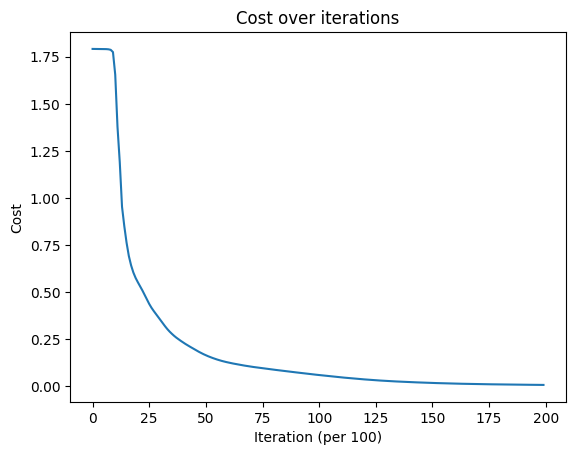

In [26]:
# Масштабування ознак (видалено колонки 'Ba' і 'Fe', вони не потрібні (виявлено в ході експерименту))
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(['Ba', 'Fe'], axis=1))
X_test_scaled = scaler.transform(X_test.drop(['Ba', 'Fe'], axis=1))

# Функція для перепризначення (перенумерації) класів, 
# щоб виключити відсутні в даних класи (0 та 4) та зробити номери класів послідовними
def reassign_labels(y, mapping):
    y_new = np.copy(y)
    for old, new in mapping.items():
        y_new[y == old] = new
    return y_new

# Визначення відповідності старих класів новим без пропусків
mapping = {1:0, 2:1, 3:2, 5:3, 6:4, 7:5}
# Перепризначення класів для тренувальних та тестових міток
y_train_new = reassign_labels(y_train.to_numpy().flatten(), mapping)
y_test_new = reassign_labels(y_test.to_numpy().flatten(), mapping)

# Кодування нових міток у формат one-hot (потрібно для softmax-активації)
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train_new.reshape(-1,1))

# Ініціалізація нейронної мережі з двома прихованими шарами та softmax на виході
nn = NeuralNet(
    hidden_layers=[100, 50],
    hidden_activations=['relu', 'relu'],
    output_activation='softmax',
    learning_rate=0.05,
    num_iter=20000,
    normalize=True,
    early_stopping=True,
    patience=1000
)
nn.fit(X_train_scaled, y_train_onehot)

In [27]:
# Отримання передбачень
y_pred = nn.predict(X_test_scaled)

# Вивід метрик
print("\nTest Set Evaluation for DNN:")
print("Accuracy:", accuracy_score(y_test_new, y_pred))
print("Classification Report:\n", classification_report(y_test_new, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_new, y_pred))



Test Set Evaluation for DNN:
Accuracy: 0.7441860465116279
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.64      0.75        14
           1       0.73      0.73      0.73        15
           2       0.50      1.00      0.67         3
           3       1.00      0.67      0.80         3
           4       0.50      0.50      0.50         2
           5       0.75      1.00      0.86         6

    accuracy                           0.74        43
   macro avg       0.73      0.76      0.72        43
weighted avg       0.78      0.74      0.75        43

Confusion Matrix:
 [[ 9  3  2  0  0  0]
 [ 1 11  1  0  1  1]
 [ 0  0  3  0  0  0]
 [ 0  1  0  2  0  0]
 [ 0  0  0  0  1  1]
 [ 0  0  0  0  0  6]]


In [28]:
# Отримання передбачень
y_pred = final_model.predict(X_test)

# Вивід метрик
print("\nTest Set Evaluation for RF:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Test Set Evaluation for RF:
Accuracy: 0.7906976744186046
Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.79      0.85        14
           2       0.83      0.67      0.74        15
           3       0.43      1.00      0.60         3
           5       1.00      1.00      1.00         3
           6       0.67      1.00      0.80         2
           7       0.83      0.83      0.83         6

    accuracy                           0.79        43
   macro avg       0.78      0.88      0.80        43
weighted avg       0.84      0.79      0.80        43

Confusion Matrix:
 [[11  1  2  0  0  0]
 [ 1 10  2  0  1  1]
 [ 0  0  3  0  0  0]
 [ 0  0  0  3  0  0]
 [ 0  0  0  0  2  0]
 [ 0  1  0  0  0  5]]


In [29]:
# Збереження моделі
model_path = '../models/glass_best_model.pkl'

joblib.dump(final_model, model_path)
print(f"Model saved to {model_path}")

Model saved to ../models/glass_best_model.pkl


# Висновок

У цьому проєкті було проведено комплексний аналіз класифікації типів скла з використанням різних моделей машинного навчання. 
- **EDA та Preprocessing**: Спочатку дані пройшли очистку від викидів методом IQR, а також було застосовано балансування класів за допомогою SMOTE для покращення якості навчання. Для попередньої обробки ознак використовували трансформацію Yeo-Johnson, що допомагає нормалізувати розподіл ознак.
- **Model Selection**: Далі були порівняні кілька класифікаторів, зокрема Logistic Regression, KNN, Random Forest та Gradient Boosting, з оцінкою за допомогою крос-валідації. Найкращою моделлю виявився Random Forest, для якого було проведено тонкий підбір гіперпараметрів (GridSearchCV), що додатково покращило результати.
- **Feature Selection and Hyperparameter Tuning**: Для оптимізації моделі було також проведено аналіз важливості ознак і вибір оптимального набору гіперпараметрів на основі їх внеску в класифікацію.
- **RF comparsion with DNN**: Окрім класичних моделей, для порівняння була навчена глибока нейронна мережа (DNN). Хоча вона показала прийнятну точність (72%), Random Forest продемонстрував вищу точність (79%) та кращу збалансованість метрик якості (precision, recall, f1-score).

Отже, результати свідчать, що для задачі класифікації типів скла класичний алгоритм Random Forest із попередньою обробкою та тюнінгом гіперпараметрів є більш ефективним і стабільним, ніж нейронна мережа на цих даних.
